## Satisfactory Reviews - An NLP Project

Earlier this year, I discovered a wonderful game named Satisfactory. I immediately fell in love with the concept of landing on an unknown planet, where the only goal is to use the planet's resources to build the ultimate factory. With a huge map jampacked with resouces, aliens and poisonous clouds (and lizard doggos!) - one has to locate resources, build factories, and spend an inordinate amount of time just making the process more efficient. 

*MUST INCREASE EFFICIENCY AT ALL COSTS*

As a data scientist (who willingly spent a ridiculous amount of time increasing the efficiency of everything), I needed to know what others had to say about this game. I built a webscraper that took in user reviews of Satisfactory from the Steam community website, and pulled around 6000 reviews from the past few months since the last major update. 

I wanted to focus on those that wrote a review, recommended (or not), the length of the review, and how long they've played the game. Using this data, we'll be able to draw insights into what are words commonly said across all reviews, and determine if the length of time played in the game affects their recommendation or not. 

My current hypothesis is thus:  

*Players that log at least 50 hours in the game will recommend this game to others.* 



We'll start by pulling in all the relevant libraries first. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm

plt.style.use('ggplot')

In [2]:
# reading in the dataframe
df = pd.read_csv(r"C:\Users\Katya\Documents\GitHub\SF-Project\Steam_Reviews_526870_20210803.csv")

# take a quick peek
df.head(10)

,SteamId,ProfileURL,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted
0,7.65612E+16,https://steamcommunity.com/profiles/7656119884...,EARLY ACCESS REVIEW\r\n0yuyou9yfui9ftrygyg6ftd...,Recommended,59,36.6 hrs on record,Posted: August 3
1,7.65612E+16,https://steamcommunity.com/profiles/7656119829...,EARLY ACCESS REVIEW\r\nHm.I think it's a good ...,Recommended,40,24.3 hrs on record,Posted: August 3
2,7.65612E+16,https://steamcommunity.com/profiles/7656119816...,EARLY ACCESS REVIEW\r\nI uhh....... already fe...,Recommended,59,21.7 hrs on record,Posted: August 3
3,7.65612E+16,https://steamcommunity.com/profiles/7656119820...,"EARLY ACCESS REVIEW\r\nIts pretty cool, really...",Recommended,60,4.4 hrs on record,Posted: August 3
4,7.65612E+16,https://steamcommunity.com/profiles/7656119907...,EARLY ACCESS REVIEW\r\nvery good,Recommended,26,5.6 hrs on record,Posted: August 3
5,7.65612E+16,https://steamcommunity.com/profiles/7656119831...,EARLY ACCESS REVIEW\r\nThe game where u watch ...,Recommended,106,216.7 hrs on record,Posted: August 3
6,7.65612E+16,https://steamcommunity.com/profiles/7656119903...,EARLY ACCESS REVIEW\r\nIt's addicting!,Recommended,32,403.6 hrs on record,Posted: August 3
7,7.65612E+16,https://steamcommunity.com/profiles/7656119904...,EARLY ACCESS REVIEW\r\nThis game is already in...,Recommended,88,77.9 hrs on record,Posted: August 3
8,burakyilmaz,https://steamcommunity.com/id/burakyilmaz/,"EARLY ACCESS REVIEW\r\nIf you like automation,...",Recommended,213,393.0 hrs on record,Posted: August 3
9,Merleo,https://steamcommunity.com/id/Merleo/,EARLY ACCESS REVIEW\r\nAfter the fun i have be...,Recommended,875,76.9 hrs on record,Posted: August 3


### Data Dictionary 

The dataframe contains information from a few points of view: 

- `SteamID`: The steam ID of the player
- `ProfileURL`: The link to the profile of the player
- `ReviewText`: The review text content 
- `Review`: Shows whether if the player recommends this game or not 
- `ReviewLength(Chars)`: The length of the review
- `PlayHours`: The amount of hours played 
- `DatePosted`: When the review was posted 

### Basic Cleaning
Now that we have an idea of what columns are, we'll go ahead with some basic cleaning of the columns. Since we're not focusing on the user profiles of the customers in this project, we'll be dropping the `SteamId` and `ProfileURL` columns next. 




In [3]:
# dropping user information
df.drop(['SteamId', 'ProfileURL'], axis=1, inplace=True)

With the user information removed, we'll start with cleaning the `ReviewText` column, by removing the "EARLY ACCESS REVIEW" text at the beginning of each line. While this was being scraped from the website, the review content box also included the "Early Access Review" icon, which was collected together. 

In [4]:
# cleaning the review text column (removing the EARLY ACCESS REVIEW)
df['ReviewText'] = df['ReviewText'].str.replace('EARLY ACCESS REVIEW\r\n', '')

#sanity check
df

,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted
0,0yuyou9yfui9ftrygyg6ftdryujiouhyeasrtgf4r,Recommended,59,36.6 hrs on record,Posted: August 3
1,Hm.I think it's a good game,Recommended,40,24.3 hrs on record,Posted: August 3
2,I uhh....... already feel my body getting fatter,Recommended,59,21.7 hrs on record,Posted: August 3
3,"Its pretty cool, really slow however in the st...",Recommended,60,4.4 hrs on record,Posted: August 3
4,very good,Recommended,26,5.6 hrs on record,Posted: August 3
...,...,...,...,...,...
6175,It is such a complex grinding game :),Recommended,48,157.2 hrs on record,Posted: April 18
6176,"Terrible early access game, literally nothing ...",Recommended,63,394.7 hrs on record,Posted: April 18
6177,bean,Recommended,22,186.1 hrs on record,Posted: April 18
6178,This game tells me that i have too much free time,Recommended,57,143.8 hrs on record,Posted: April 18


Before getting deeper with text cleaning using the NLTK library, we'll also have some other columns that need paying attention to. Namely, `DatePosted` has "Posted: " right before the date - this will be removed. Secondly, the `PlayHours` column contains "hrs on record" right after the number of hours. This information is not useful for us, and that will also be removed. 

In [5]:
# cleaning DatePosted to have only the dates
df['DatePosted'] = df['DatePosted'].str.replace('Posted: ', '')

# cleaning PlayHours to contain only the numerical values
df['PlayHours'] = df['PlayHours'].str.replace(' hrs on record', '')

# renaming some columns
df.rename(columns={'ReviewLength(Chars)':'CharLenOfReview'})

,ReviewText,Review,CharLenOfReview,PlayHours,DatePosted
0,0yuyou9yfui9ftrygyg6ftdryujiouhyeasrtgf4r,Recommended,59,36.6,August 3
1,Hm.I think it's a good game,Recommended,40,24.3,August 3
2,I uhh....... already feel my body getting fatter,Recommended,59,21.7,August 3
3,"Its pretty cool, really slow however in the st...",Recommended,60,4.4,August 3
4,very good,Recommended,26,5.6,August 3
...,...,...,...,...,...
6175,It is such a complex grinding game :),Recommended,48,157.2,April 18
6176,"Terrible early access game, literally nothing ...",Recommended,63,394.7,April 18
6177,bean,Recommended,22,186.1,April 18
6178,This game tells me that i have too much free time,Recommended,57,143.8,April 18


### Assigning Binary Classification to Recommendations
Next we'll use the `map()` function to assign binary values to the `Review` column (0,1) so that the data is more intrepretable. 

In [6]:
# assigning binary values for Review column (1 for Recommended, 0 for Not Recommended)
df['Review'] = df['Review'].map({'Recommended': 1, 'Not Recommended': 0})

#sanity check
df.head()

,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted
0,0yuyou9yfui9ftrygyg6ftdryujiouhyeasrtgf4r,1,59,36.6,August 3
1,Hm.I think it's a good game,1,40,24.3,August 3
2,I uhh....... already feel my body getting fatter,1,59,21.7,August 3
3,"Its pretty cool, really slow however in the st...",1,60,4.4,August 3
4,very good,1,26,5.6,August 3


Let's find out the proportion of those that recommend the game or not, and how much of the total population they represent. 

In [7]:
# counting the total number of users that recommend the game
total_recommended = df.Review[df['Review'] == 1].count()

# counting the total number of users that don't recommend the game
total_not_recommended = df.Review[df['Review'] == 0].count()

print(f"There are {total_recommended} players that recommend the game, and {total_not_recommended} that don't recommend this game.")
print("*" * 100)
print(f"Those that recommend the game account for {'{:.2f}'.format((total_recommended/len(df))*100)}% of the total.")
print(f"People who don't recommend the game account for {'{:.2f}'.format((total_not_recommended/len(df))*100)}% of the total.")

There are 5985 players that recommend the game, and 195 that don't recommend this game.
****************************************************************************************************
Those that recommend the game account for 96.84% of the total.
People who don't recommend the game account for 3.16% of the total.


### Exploring the Play Time of Users

The majority of users that played the game recommended the game to others. Now we'll look a little deeper into what consistutes their recommendations, and if there is a connection between their play time or not. Let's take a high level look at the statistics of users play times in hours. 

In [8]:
# lets double check the dtypes to make sure that the relevant columns are numerical
df.dtypes

ReviewText             object
Review                  int64
ReviewLength(Chars)     int64
PlayHours              object
DatePosted             object
dtype: object

The `PlayHours` column is listed as an object, we'll need to change this value to a float. We'll also be removing the comma from the column values in order to compute it a numerical value. 

In [9]:
# removing the comma from the hours column in order to change the values to a float
df.PlayHours = df.PlayHours.str.replace(',', '')

# assigning the dtype of the column to float
df.PlayHours = df.PlayHours.astype(float)

In [10]:
# grouping the recommended column, and pulling statistical information on the PlayHours such as the mean, min, max and std
df.groupby(df.Review).agg({'PlayHours': ['mean', 'min', 'max', 'std']})

PlayHours                         
              mean  min     max         std
Review                                     
0        99.226667  0.1  2034.1  235.936175
1       116.232815  0.2  4087.9  189.626862

#### Quick Overview of the Play Time of Users

The average number of hours that users logged are very similar for those that recommended the game or not. 

For those that don't recommend the game to others, the average play hours is 99.2. The highest number of hours a user has is 2034 hours, and despite such a high amount of time played these users didn't recommend the game. I'm curious as to why they would invest such a inordinate amount of time playing this game, and still not recommend it to others. The standard deviation for this group is 235.9 hours, higher than those that recommend the game (which was 189.6). This suggests that the number of hours played in this game is more spread out from the average, with more variance. 

Whereas for those that recommend the game, the average playtime is around 116.2 hours, with a max of 4087.9 hours, and a standard deviation of 189.6. With the standard deviation being lower than those that didn't recommend the game, this suggests that the values distributed are not as spread out (less variance). 

#### Quick to Judge? 
However, it seems that there are users that played the game for less than one hour as well, with both outcomes. Let's take a look at how many users played the game for only one hour or less. 

In [11]:
# filtered players that recommended the game with less than a hour of gameplay
one_hour_played_no = df.Review[(df.Review == 0) & (df.PlayHours <= 1)].count()

# filtered players that didn't recommend the game with less than a hour of gameplay
one_hour_played_yes = df.Review[(df.Review == 1) & (df.PlayHours <= 1)].count()

print(f"There are {one_hour_played_no} users that played the game for at least one hour that did NOT recommend the game.")
print(f"There are {one_hour_played_yes} users that played the game for at least one hour, and recommended the game.")

There are 16 users that played the game for at least one hour that did NOT recommend the game.
There are 12 users that played the game for at least one hour, and recommended the game.


Out of all that didn't recommend the game, only 8% of the population played the game for less than an hour. On the other hand, for those that recommened it... only 0.2% of the population immediately recommended Satisfactory from less than one hour of gameplay. 

Let's look at the distribution of the playtime for both outcomes. There are certainly some outliers for both scenarios, let's determine where they lie. 

Text(0, 0.5, 'Play Hours')

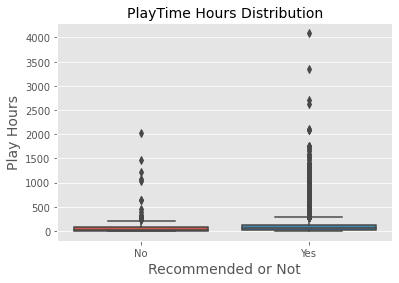

In [12]:
# instiate the plot
sns.boxplot(x=df.Review, y=df.PlayHours)
plt.title('PlayTime Hours Distribution', size=14)
plt.xlabel('Recommended or Not', size=14)
# creating a custom label 
plt.xticks([0,1], ['No', 'Yes'])
plt.ylabel('Play Hours', size=14)

Off the bat, there is a large number of outliers for both decisions. It seems that around the 250 hour playtime mark, outliers go as far as 4000 hours for recommended games, and 2000 for the latter. 

The maximum of the distribution in both scenarios seem to be around the 500 hour point. We'll adjust the range of the y value so that we can see the boxplot information more clearly. 

(0.0, 500.0)

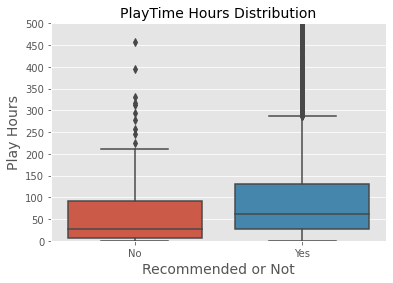

In [13]:
# instantiate the boxplot
sns.boxplot(x=df.Review, y=df.PlayHours)
plt.title('PlayTime Hours Distribution', size=14)
plt.xlabel('Recommended or Not', size=14)
# create custom label
plt.xticks([0,1], ['No', 'Yes'])
# customer y ticks
plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
plt.ylabel('Play Hours', size=14)
# create y limit of 500 hours
plt.ylim(0,500)

#### Boxplots of PlayTime vs Recommendations

The plots shown above visually describe the statistical overview that we explored earlier. In order to visually understand a boxplot, I've attached a visual guide. 

![alt text](boxplot_describe.png "BoxPlot")

From the plot, we can see that for those that didn't like the game, the maximum value is around 200 hours, whereas for those the loved the game is around 300 hours. There aren't a lot of players that play more than 300 hours on average, and they are considered outliers (because there are less than 20 people that are in this group for both scenarios). 

However, we'll leave these values in the dataframe for EDA purposes. When we begin feature engineering for our machine learning models, we'll most likely remove these outliers for a more accurate prediction. 

#### Does Receiving the Game for Free Impact Recommendations? 

Another worthy area to look into is those that received the game for free, and see if they played the game for a good period of time (say around 10 hours), and if they recommended the game or not. Does the standard deviation in those that received the game for at no cost have a similar distribution of play hours vs those that purchased the game? 

We'll begin by creating a new column where numpy finds the phrase, "Product received for free" inside the `ReviewText` column. If it appears in there, then a value of 1 is assigned, else 0. 

In [14]:
# creatinga new column where (1, 0) is assigned if the user received the game free of charge or not
df['ReceivedFree'] = np.where(df.ReviewText.str.contains('Product received for free'), 1, 0)

# sanity check to see how many users received the game for free
df[df.ReceivedFree == 1]

,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted,ReceivedFree
14,Product received for free\r\n\r\nit good,1,48,11.0,August 3,1
31,Product received for free\r\n\r\nyes,1,45,4.0,August 2,1
68,Product received for free\r\n\r\nMUST EXPAND F...,1,191,88.4,August 1,1
138,Product received for free\r\n\r\nGreat relaxin...,1,270,2711.1,July 31,1
230,Product received for free\r\n\r\nits ment for ...,1,72,7.3,July 28,1
...,...,...,...,...,...,...
5834,Product received for free\r\n\r\nThis game is ...,1,85,6.5,April 20,1
5912,Product received for free\r\n\r\ni like it,1,49,31.8,April 20,1
6058,Product received for free\r\n\r\nI like it cau...,1,101,5.2,April 19,1
6076,Product received for free\r\n\r\nbuild factory...,1,94,21.0,April 19,1


There are 105 users in this dataframe that received the game for free! I wonder how many of these reviews have users that did NOT recommend the game, but still received it for free. 

In [15]:
df[(df.ReceivedFree == 1) & (df.Review == 0)]

,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted,ReceivedFree
640,Product received for free\r\n\r\n♥♥♥♥♥♥♥,0,49,28.9,July 18,1
4118,Product received for free\r\n\r\nIF YOU LOVE S...,0,314,457.4,May 15,1
5076,Product received for free\r\n\r\nCRinge,0,48,4.2,April 30,1


There are only 3 users that did not recommend the game, despite receiving it for free. 

Now that we've created our new column, we'll remove the string inside the `ReviewText` column now. 

In [16]:
# removing the string "product received for free" inside the review content column
df.ReviewText = df.ReviewText.str.replace('Product received for free\r\n\r\n', '')

# sanity check
df[df.ReceivedFree == 1]

,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted,ReceivedFree
14,it good,1,48,11.0,August 3,1
31,yes,1,45,4.0,August 2,1
68,MUST EXPAND FACTORY. DRIVE OUT THE LOCALS. KIL...,1,191,88.4,August 1,1
138,Great relaxing game with strong modding commun...,1,270,2711.1,July 31,1
230,its ment for develapers or thinkers,1,72,7.3,July 28,1
...,...,...,...,...,...,...
5834,"This game is good, but multiplayer crashes so ...",1,85,6.5,April 20,1
5912,i like it,1,49,31.8,April 20,1
6058,I like it cause it is good for like people who...,1,101,5.2,April 19,1
6076,build factory then build more factory then bui...,1,94,21.0,April 19,1


In [17]:
df[df.Review == 0].sort_values('PlayHours', ascending=False)

,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted,ReceivedFree
4237,sorry i cannot recommend this game it has many...,0,588,2034.1,May 13,0
4039,This would be a GREAT game if it actually had ...,0,212,1469.6,May 16,0
3868,"if you can get it to load ,it's a good game ,i...",0,119,1228.7,May 19,0
3856,"The game is awesome, but there is one MAJOR is...",0,316,1073.8,May 20,0
3808,"My experience with this game has been, for the...",0,845,1026.1,May 21,0
...,...,...,...,...,...,...
4798,***EARLY ACCESS IMPRESSIONS***\r\n\r\nThe main...,0,226,0.3,May 4,0
3537,"Never worked on start up, always crashed.\r\nv...",0,197,0.2,May 27,0
1173,Spent a hour trying to get it do something bes...,0,108,0.2,July 7,0
426,"no controller support , cant recommend until t...",0,67,0.1,July 23,0
